<a href="https://colab.research.google.com/github/sota1111/DL_Zero4/blob/main/DL_Zero4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy matplotlib ipython scikit-learn pandas pillow dezero gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!apt update
!apt install xvfb

Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [902 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 

In [3]:
!pip install pyvirtualdisplay

from pyvirtualdisplay import Display

d = Display()
d.start()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!apt update && apt install xvfb
!pip install gym-notebook-wrapper

Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

# 8章 DQN
DQN：Q学習とニューラルネットワークを使った手法。  
前章から「経験再生」と「ターゲットネットワーク」が使われる。  

## 8.1 OpenAI Gym

### 8.1.1 OpenAI Gymの基礎知識

In [ ]:
import gym
env = gym.make('CartPole-v0')

state = env.reset()
print(state)

action_space = env.action_space
print(action_space)

In [ ]:
action = 0
next_state, reward, done, info = env.step(action)
print(next_state)

### 8.1.2 ランダムなエージェント

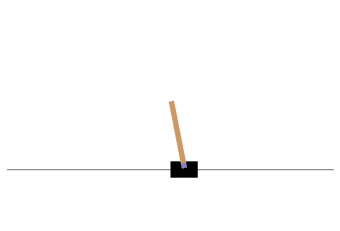

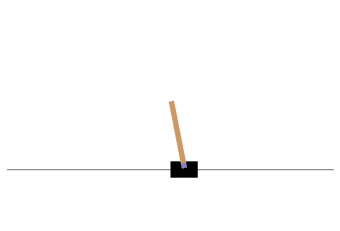

In [12]:
import gnwrapper
import gym
import numpy as np

env = gym.make('CartPole-v0')
env_gnw = gnwrapper.Animation(env) # Xvfbが起動される

state = env.reset()
done = False

while not done:
  env_gnw.render() # ここで、前の描画を消し、新しいステップの描画を行う。
  action = np.random.choice([0, 1])
  next_state, reward, done, info = env.step(action) # 本当はDNNからアクションを入れる
env.close()